In [21]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
df_wine.columns = ["class","alcohol", "malic_acid", "ash", "alcalinity_of_ash", "magnesium","total_phenols", "flavanoids", "nonflavanoid_phenols", "proanthocyanins","color_intensity", "hue", "od280_od315", "proline"]

from sklearn.model_selection import train_test_split

X = df_wine.iloc[:,1:].values
Y = df_wine.iloc[:,0].values

x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size= 0.3, stratify= Y)

from sklearn.preprocessing import StandardScaler

SSC =  StandardScaler()
x_train_std = SSC.fit_transform(x_train)
x_test_std =  SSC.transform(x_test)


# Computing D dimensional mean

Note: Each mean vector, mi, stores the mean feature value Um , with respect to the examples of class i
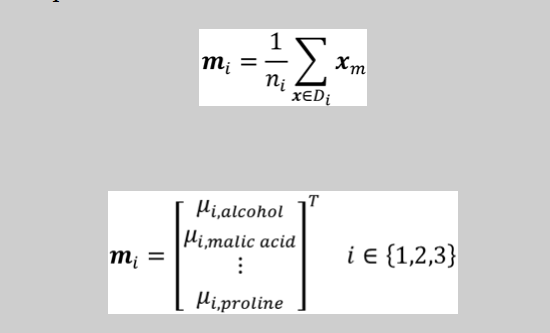

These mean vectors can be computed by the following code, where we compute one mean vector for each of the three labels:
Note:
- Within-class scatter: how spread out samples are around their class mean.
- Between-class scatter: how far apart the class means are from each other..


In [22]:
import numpy as np

np.set_printoptions(precision = 4) # DEcimal places
mean_vecs = []

for label in range(1,4):
    mean_vecs.append(np.mean(x_train_std[label == y_train], axis = 0))

    print(f"the Mv {label} : {mean_vecs[label - 1]}\n")
    # It took the values belongingto current class
    
    


the Mv 1 : [ 0.9116 -0.315   0.3551 -0.7261  0.4242  0.8264  0.9072 -0.5897  0.4762
  0.2125  0.4735  0.7662  1.1914]

the Mv 2 : [-0.8847 -0.3343 -0.4206  0.283  -0.3427  0.0165  0.0999  0.0359  0.1922
 -0.8365  0.3894  0.2367 -0.7232]

the Mv 3 : [ 0.2079  0.8979  0.1962  0.4734 -0.0078 -1.0518 -1.2784  0.6783 -0.8828
  1.0035 -1.1783 -1.3105 -0.3845]



Note: 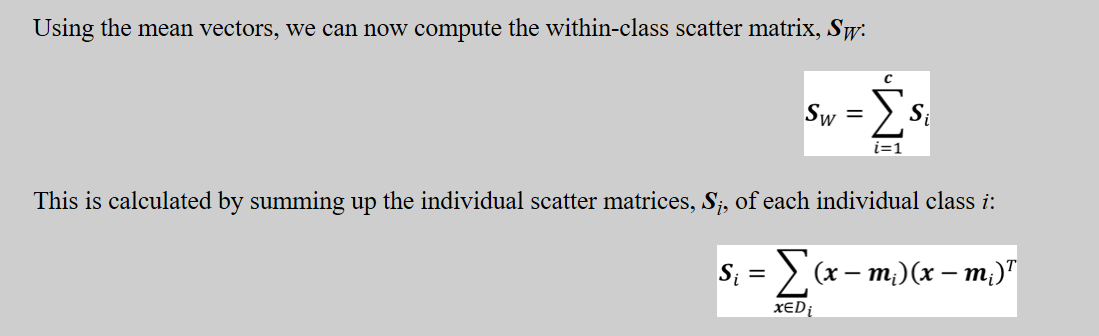

In [23]:
d =  13
S_W = np.zeros((d,d))

for labels, mv in zip(range(1,4),mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in x_train_std[y_train == labels]:
        row,mv = row.reshape(d,1),mv.reshape(d,1)
        class_scatter += (row - mv) * (row - mv).T

    S_W += class_scatter

# Lets take a look if the class is uniform

print(f"The class label  is{np.bincount(y_train)[1:]}")

# Ain`t uniform



The class label  is[41 50 33]


In the previous cell we saw the class is not uniform 1: 41, 2:50 ..
Therefore to avid bias we scale each class scatter Si by dividing the number of sample in that class(ni) [[Coverancce matrix]]
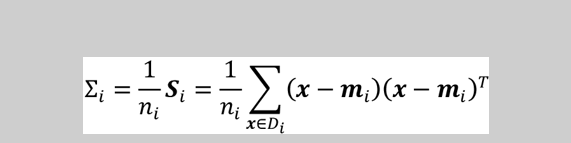

In [24]:
d = 13
S_w = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(x_train_std[y_train == label].T)
    S_w += class_scatter
    

Computing In between Scatter matrix 
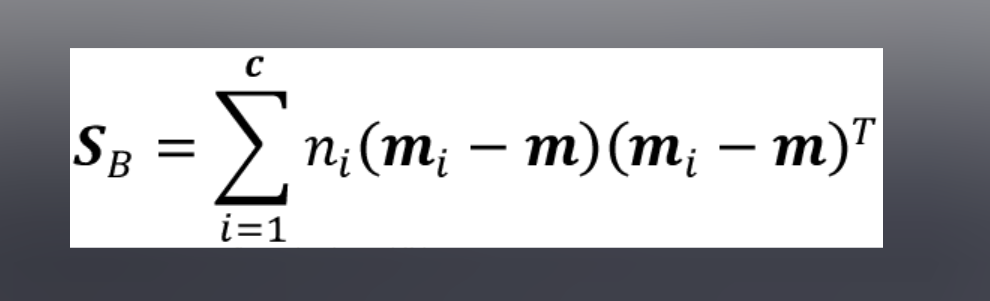

In [25]:
mean_overall = np.mean(x_train_std,axis = 0)

mean_overall = mean_overall.reshape(d,1)
S_B = np.zeros((13,13))

for i, mv in enumerate(mean_vecs):
    n = x_train_std[i+1,:].shape[0]
    #counting number of row / class
    mv = mv.reshape(d,1)
    S_B += n*(mv-mean_overall).dot((mv-mean_overall).T)

print(f'Between class is {S_B.shape[0]} * {S_B.shape[1]} ')


Between class is 13 * 13 


# SELECTING LINEAR DISCRIMINANT FOR THE NEW FEATURE 
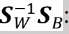

121.49597150217804
48.20566517057401
1.859374481361896e-14
1.13341166696292e-14
1.13341166696292e-14
9.084678710456352e-15
6.9065835856988705e-15
5.130677743305278e-15
2.3974465674079334e-15
2.3945797173443057e-15
2.3945797173443057e-15
4.305259319176336e-16
0.0


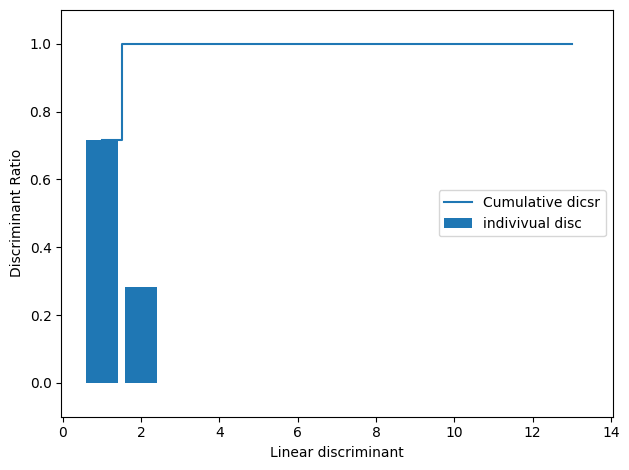

In [26]:
import matplotlib.pyplot as plt

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

tot = sum(eigen_vals.real)

discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]

cum_disc = np.cumsum(discr)

plt.bar(range(1,14), discr, align = 'center', label = 'indivivual disc')
plt.step(range(1,14), cum_disc, where  = 'mid', label = "Cumulative dicsr")

plt.ylabel("Discriminant Ratio")
plt.xlabel("Linear discriminant")
plt.ylim([-0.1,1.1])
plt.legend(loc = "best")
plt.tight_layout()
plt.show()


# Projecting examples onto the new feature space

Matrux iz[[-0.1256 -0.4527]
 [ 0.053  -0.1568]
 [-0.0235 -0.3553]
 [ 0.172   0.3367]
 [ 0.0206 -0.0206]
 [ 0.2082  0.0269]
 [-0.7309  0.2213]
 [-0.0787  0.0946]
 [ 0.0138  0.1729]
 [ 0.2722 -0.2104]
 [-0.154   0.2196]
 [-0.3563  0.0462]
 [-0.377  -0.5893]]


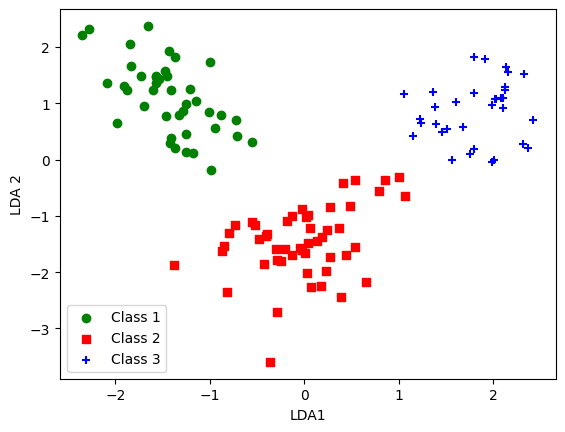

In [29]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real, eigen_pairs[1][1][:,np.newaxis].real))
print(f"Matrux iz{w}")
X_train_lda = x_train_std.dot(w)

colors = ['g','r','b']
markers = ['o','s', '+']
for l,c,m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l,0],X_train_lda[y_train==l, 1] * (-1), c = c, label = f"Class {l}", marker  = m)

plt.xlabel("LDA1")
plt.ylabel("LDA 2")
plt.legend(loc = "best")




# LDA VIA SCIKIT